In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import *
from ipywidgets import interact
import ipywidgets as widgets

import OpenVisus as ov

# Enable I/O component of OpenVisus
ov.DbModule.attach();

Starting OpenVisus /home/philip/.local/lib/python3.6/site-packages/OpenVisus/__init__.py 3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0] sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0) ...


In [4]:
dataset=ov.LoadDataset("https://atlantis.sci.utah.edu/mod_visus?dataset=BlueMarble")
# print(dataset.getDatasetBody().toString())
print('max resolution:', dataset.getMaxResolution())
print(dataset.getTimesteps().toString())

max resolution: 33
<DatasetTimesteps>
	<timestep from="0" to="11" step="1" />
</DatasetTimesteps>


<IPython.core.display.Javascript object>


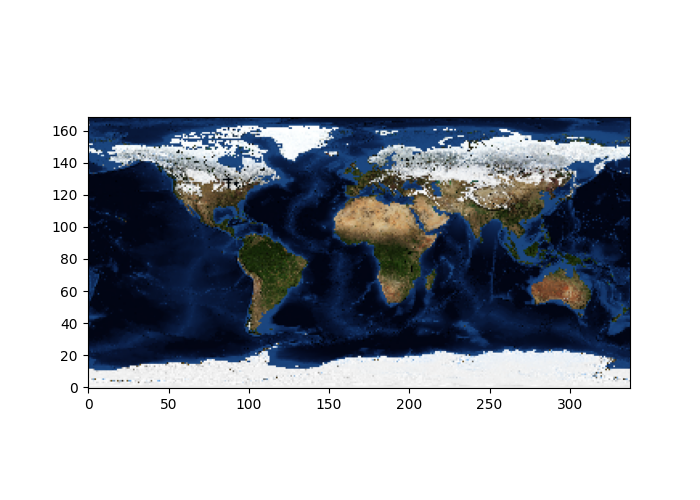

In [3]:
#####
# 1 #
#####

def imshow(data, cmap=None, new_fig=True, ax=None):
    if len(data.shape)==3 and data.shape[0]==1: data=data[0,:,:]
    if len(data.shape)==3 and data.shape[1]==1: data=data[:,0,:]   
    if len(data.shape)==3 and data.shape[2]==1: data=data[:,:,0]
    if(new_fig):
        fig = plt.figure(figsize=(7,5))
    if ax is not None:
        ax.imshow(data, origin='lower', cmap=cmap)
    else:
        plt.imshow(data, origin='lower', cmap=cmap)
#     plt.show()
    
imshow(dataset.read(max_resolution=17, time=0))

<IPython.core.display.Javascript object>


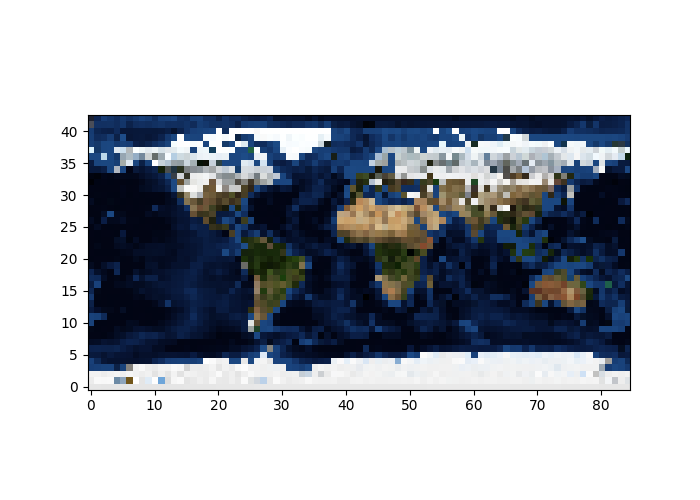

interactive(children=(IntSlider(value=0, description='time', max=11), IntSlider(value=13, description='resolut…

In [4]:
#######
# 2-3 #
#######

plot = plt.figure(figsize=(7,5))

def show(time, resolution):
    imshow(dataset.read(max_resolution=resolution, time=time), new_fig=False)

time_slider = widgets.IntSlider(min=0, max=11, step=1, value=0)
resolution_slider = widgets.IntSlider(min=5, max=21, step=4, value=13)
interact(show, time=time_slider, resolution=resolution_slider);

<IPython.core.display.Javascript object>


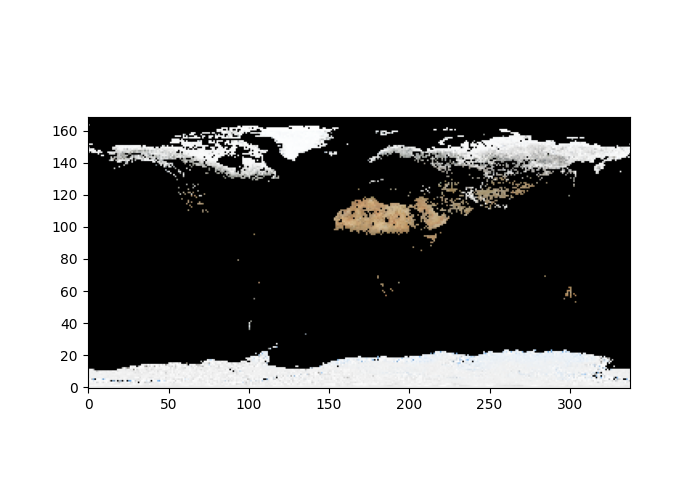

interactive(children=(IntSlider(value=0, description='time', max=11), IntSlider(value=13, description='resolut…

In [24]:
#######
# 4-5 #
#######

def make_greyscale(data):
    '''
    make a "grey scale" version of the data
    from Matlab "rgb2gray" 0.2989 * R + 0.5870 * G + 0.1140 * B (standard ITU-R BT.601-7)
    '''
    R,G,B=(0.2989*data[:,:,0], 0.5870*data[:,:,1], 0.1140*data[:,:,2])
    return R+G+B

def filter_threshold(data, threshold, copy=True):
    if copy: data = data.copy()
    grey = make_greyscale(data)
    data[grey < threshold] = 0.0
    return data
    
plot = plt.figure(figsize=(7,5))
ax = plot.add_subplot(1,1,1)

_time = 0
_resolution = 13
_threshold = 210
_data = dataset.read(max_resolution=_resolution, time=_time)

def show(time, resolution, threshold):
    global _data, _time, _resolution, _threshold
    if _time != time or _resolution != resolution:
        _data = dataset.read(max_resolution=resolution, time=time)
#     data = _data.copy()
#     grey = make_grey_scale(data)
#     data[grey < threshold] = 0.0
    data = filter_threshold(_data, threshold)
    imshow(data, new_fig=False,  ax=ax)
    
    _time = time
    _resolution = resolution

time_slider = widgets.IntSlider(min=0, max=11, step=1, value=_time)
resolution_slider = widgets.IntSlider(min=5, max=21, step=4, value=_resolution)
threshold_slider = widgets.IntSlider(min=0, max=256, step=1, value=_threshold)
interact(show, time=time_slider, resolution=resolution_slider, threshold=threshold_slider);

In [6]:
from functools import reduce

def get_density(data, threshold):
    count = (make_greyscale(data) > threshold).sum()
    size = reduce(lambda a,b: a*b, data.shape, 1)
    density = count / size
    return density

In [8]:
#######
# 5.1 #
#######

# Code used to precompute the snow densities
# This code is slow, computed densities were saved and loaded in the next cell

threshold = 210
resolutions = [5, 9, 13, 17, 21, 25]
times = list(range(12))
all_ys = np.empty([len(resolutions), len(times)])
for i, resolution in enumerate(resolutions):
    print(f'{resolution:>2}:', end=' ')
    for j, time in enumerate(times):
        print(time, end=' ')
        data = dataset.read(max_resolution=resolution, time=time)
        d = get_density(data, threshold)
        all_ys[i][j] = d
    print()
    
np.save('precomputed_densities.npy', all_ys)
print('done')

 5: 0 1 2 3 4 5 6 7 8 9 10 11 
 9: 0 1 2 3 4 5 6 7 8 9 10 11 
13: 0 1 2 3 4 5 6 7 8 9 10 11 
17: 0 1 2 3 4 5 6 7 8 9 10 11 
21: 0 1 2 3 4 5 6 7 8 9 10 11 
25: 0 1 2 3 4 5 6 7 8 9 10 11 
done


<IPython.core.display.Javascript object>


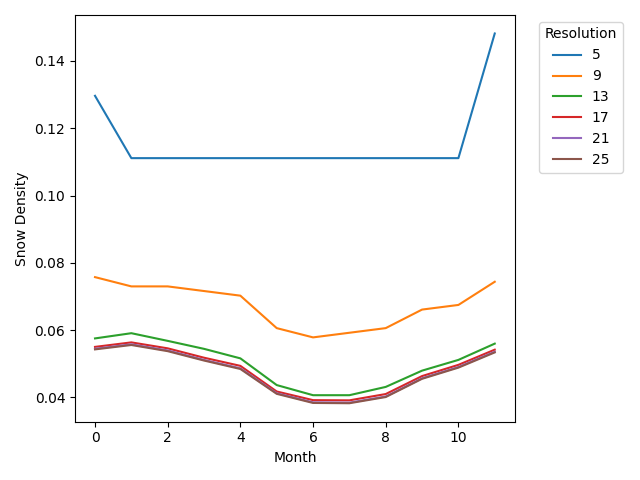

In [10]:
# precomputed densities
all_ys = np.load('precomputed_densities.npy')
resolutions = [5, 9, 13, 17, 21, 25]

plt.figure()
xs = list(range(12))
for i, ys in enumerate(all_ys):
    plt.plot(xs, ys, label=resolutions[i])
    
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Resolution")
plt.ylabel('Snow Density')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


The calculated density quickly converges by resolution 13

<IPython.core.display.Javascript object>


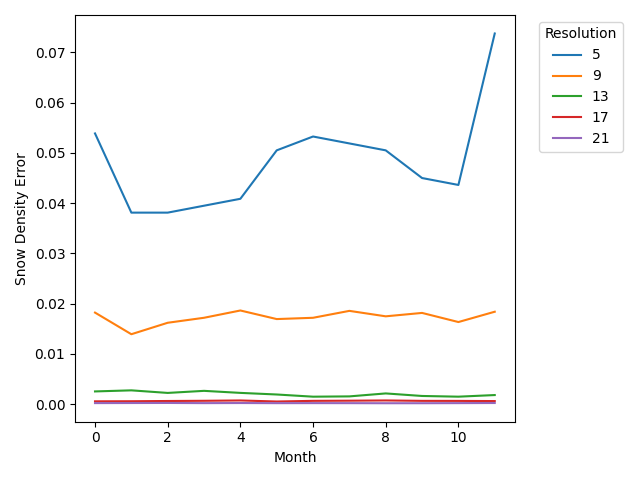

standard deviation of error
   5: 0.010001679753469384
 * 9: 0.0013463906457921973
* 13: 0.00045625326607924815
* 17: 6.418983085650335e-05
* 21: 1.6811334515083848e-05


In [26]:
#######
# 5.2 #
#######

from statistics import stdev

def get_error(a, b):
#     return np.divide(np.abs(np.subtract(a,b)), b) # relative error
    return np.abs(np.subtract(a,b)) # absolute error

resolutions = [5, 9, 13, 17, 21, 25]    
errors = map(lambda tup: get_error(tup[0], tup[1]), list(zip(all_ys, all_ys[1:])))
errors = list(errors)

plt.figure()
xs = list(range(12))
for i, ys in enumerate(errors):
    plt.plot(xs, ys, label=resolutions[i])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Resolution")
plt.ylabel('Snow Density Error')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

print('standard deviation of error')
for i, ys in enumerate(errors):
    stdeviation = stdev(ys)
    print(f'{("* " if stdeviation <= 0.002 else "") + str(resolutions[i]):>4}:', stdeviation)
    
resolutions = [resolutions[i] for i, error in enumerate(errors) if stdev(error) <= 0.002]

The standard deviation of the errors falls bellow .002 for resolutions 9, 13, 17, and 21.

In [31]:
#####
# 6 #
#####

# binary search for threshold value
def search(data, low, high, target):
    if round(low) == round(high): return low
    threshold = (low + high) / 2
    density = round(get_density(data, threshold), 2)

    if density < target: return search(data, low, threshold, target)
    if density > target: return search(data, threshold, high, target)
    return threshold

times = [0, 1, 2, 11]
densities = [0.05, 0.15]

mean_thresholds = {}

print('Mean threshold value')
for resolution in resolutions:
    total = 0
    for time in times:
        for density in densities:
            data = dataset.read(max_resolution=resolution, time=time)
            threshold = search(data, 0, 255, density)
            total = total + threshold
    mean = round(total / len(times) / len(densities), 1)
    mean_thresholds[resolution] = mean
    print(f'{resolution:>2}:', mean)

Mean threshold value
 9: 140.9
13: 134.0
17: 131.5
21: 131.5


In [18]:
#####
# 7 #
#####

xs = list(range(12))
all_densities = {}
for resolution in resolutions:
    densities = []
    for time in range(12):
        data = dataset.read(max_resolution=resolution, time=time)
        density = get_density(data, mean_thresholds[resolution])
        densities.append(density)
    all_densities[resolution] = densities
print('done')

done


<IPython.core.display.Javascript object>


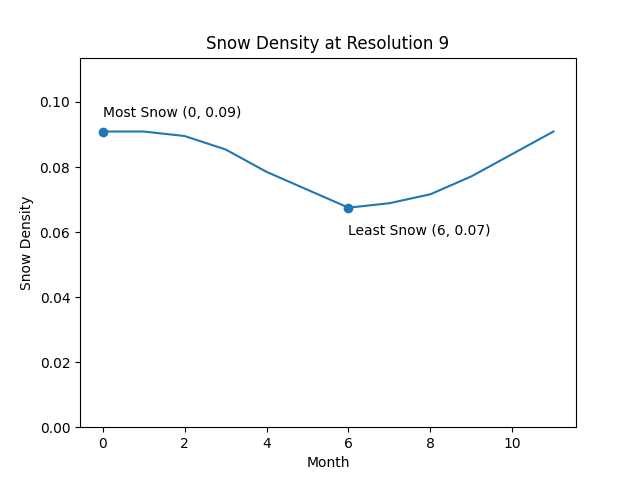

interactive(children=(IntSlider(value=9, description='resolution', max=21, min=9, step=4), Output()), _dom_cla…

In [19]:
flatten = lambda l: [item for sublist in l for item in sublist]
argmax  = lambda l: max(range(len(l)), key=lambda i: l[i])
argmin  = lambda l: min(range(len(l)), key=lambda i: l[i])

ylims = [
    0, # min(flatten(all_densities.values())) * 0.75,
    max(flatten(all_densities.values())) * 1.25
] 

plt.figure()
def show(resolution):
    plt.clf()
    plt.ylim(ylims)

    ys = all_densities[resolution]
    plt.plot(xs, ys)
    
    i = argmax(ys)
    plt.annotate(f"Most Snow {xs[i], round(ys[i], 2)}", (xs[i], ys[i]*1.05))
    
    j = argmin(ys)
    plt.annotate(f"Least Snow {xs[j], round(ys[j], 2)}", (xs[j], ys[j]*0.875))
    
    plt.scatter([xs[i], xs[j]], [ys[i], ys[j]])
    
    plt.xlabel('Month')
    plt.ylabel('Snow Density')
    plt.title(f'Snow Density at Resolution {resolution}')
    plt.show()

resolution_slider = widgets.IntSlider(min=resolutions[0], max=resolutions[-1], step=4, value=resolutions[0])
interact(show, resolution=resolution_slider);


In [23]:
#####
# 8 #
#####
resolution = 13
time = 0

y1s = []
y2s = []
xs = list(range(12))
plot = False
if plot: fig, axes = plt.subplots(12, 2, figsize=(9, 2*12))

for time in range(12):
    print(time, end=' ')
    data = dataset.read(max_resolution=resolution, time=time)

    h = len(data)
    w = len(data[1])
    q1 = np.array([data[i][:w // 2 ] for i in range(h // 2, h)])
    q2 = np.array([data[i][ w // 2:] for i in range(h // 2, h)])
    

    if plot: imshow(q1, new_fig=False, ax=axes[time][0])
    if plot: imshow(q2, new_fig=False, ax=axes[time][1])
    

    q1d = get_density(q1, 215)
    q2d = get_density(q2, 215)
    
    y1s.append(q1d)
    y2s.append(q2d)
    
if plot: plt.tight_layout()
if plot: plt.show()

0 1 2 3 4 5 6 7 8 9 10 11 

<IPython.core.display.Javascript object>


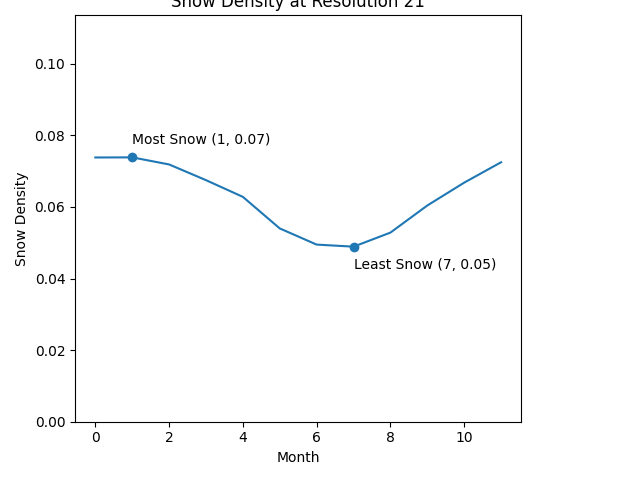

In [21]:
plt.figure()
plt.plot(xs, y1s, label='Q1')
plt.plot(xs, y2s, label='Q2')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Quadrant")
plt.ylabel('Snow Density')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


In [7]:
# Question 3

resolutions = [5, 9, 13, 17, 21]
time = 9
for resolution in resolutions:
    data = dataset.read(max_resolution=resolution, time=time)
    print(f'{resolution:>2}: {data.nbytes:>8} bytes')

 5:       54 bytes
 9:      726 bytes
13:    10965 bytes
17:   171366 bytes
21:  2733750 bytes


In [9]:
# Question 5
resolutions = [5, 9, 13, 17, 21]
time = 0
for resolution in resolutions:
    data = dataset.read(max_resolution=resolution, time=time)
    print(f'{resolution:>2}: {data.nbytes*12:>8} bytes')

 5:      648 bytes
 9:     8712 bytes
13:   131580 bytes
17:  2056392 bytes
21: 32805000 bytes


### Question 1

The embedding, or topological, dimension of the dataset is 3: 2 spacial dimensions and time

### Question 2?

The embedding dimension of the visualization for exercise 3 and 4 is 3: 2 spacial dimensions and time via the slider

### Question 3

The sizes of the numpy array in bytes for loading the dataset at resolutions [5, 9, 13, 17, 21], including in memory only timestep 9 is

| Resolution | Size (bytes) |
|------------|:-------------|
| 5          | 54           |
| 9          | 726          |
| 13         | 10965        |
| 17         | 171366       |
| 21         | 2733750      |

### Question 4

At resolution 9 there are distinct blobs of pixels for North America, South America, Africa, Eurasia, Australia, and Antarctica but at resolution 13 the continent boundaries become more clear and a rough outline is visible. At resolution 5 there are simply not enough pixels to distinguish every continent. There are 18 pixels to split between 9 continents and oceans so there is no way for that little data to represent so much information. At resolution 17 the borders become even more defined because there are more pixels to define each continent. 

### Question 5

The sizes of the numpy array in bytes for loading the dataset at resolutions [5, 9, 13, 17, 21], including in memory all the timesteps is

| Resolution | Size (bytes) |
|------------|:-------------|
| 5          | 648          |
| 9          | 8712         |
| 13         | 131580       |
| 17         | 2056392      |
| 21         | 32805000     |

### Question 6

I confirmed that winter in the norther hemisphere, when snow coverage is greater than 10% lasts from December to March. I was surprised to find that North America has more snow coverage in the 5-10% range than Eurasia.

It was very convenient to be able to work at a lower resolution while iterating on a visualization or algorithm, then easily increase the resolution for a final product. The lower resolution also makes interactive visualizations much smoother and easier to create.